In [153]:
import pandas as pd
import os, spacy, mca, nltk, pickle
import sklearn.feature_extraction
import matplotlib.pyplot as plt
import numpy as np

# We will use the smae tokenizer funtion we used last time. 

nlp = spacy.load("en_core_web_sm")
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text.lower()) # convert all tokens to lower cases. 
    return tokenized

We will use Justin Grimmer's Senator Press Release dataset for this exerice. But before analyzing the press releases, I want to first read some information about the Senators. The primary thing I care about is there party affliation. I downloaded two external sources that contain the information and built a dictionary to tell a senator's party given his/her last name. 

In [2]:
senate_df = pd.read_csv('data/term-109.csv')
senate_df['last_name'] = senate_df.sort_name.apply(lambda x: x.split(',')[0])
senate_df.index = senate_df.last_name
#senate_df.loc['Nelson', 'last_name'] = ['BenNelson', 'BillNelson']
#senate_df.index = senate_df.last_name

senate_df2 = pd.read_csv('data/term-110.csv')
senate_df2['last_name'] = senate_df2.sort_name.apply(lambda x: x.split(',')[0])
senate_df2.index = senate_df2.last_name


senate_df = pd.concat([senate_df, senate_df2.loc[list(set(senate_df2.index) - set(senate_df.index))]], axis = 0)
senate_df.loc['Nelson', 'last_name'] = ['BenNelson', 'BillNelson']
senate_df.index = senate_df.last_name

# Lastly, fix some consistency in spellings 
party_dict = senate_df.group.to_dict()
party_dict['Demint'] = party_dict['DeMint']
party_dict['Dewine'] = party_dict['DeWine']

I downloaded all of Grimmer's raw data to my local hard drive. You can find the raw data [here](https://github.com/lintool/GrimmerSenatePressReleases). The data is not included in the zip file. You will need to download it yourself in order to run the analyses. 

In [117]:
targetDir = 'data/GrimmerSenatePressReleases/raw'
folders = os.listdir(targetDir)
folders.remove('SenateClean')
folders.remove('SenateScripts')
folders.remove('Sessions')

We read all press releases into a dataframe. Note that the texts have some non-UTF8 characters. So we will need to decode the texts using 'latin-1.'

In [118]:
grimmer_texts = []
for folder in folders:
    if '.' in folder:
        pass
    else:
        path = targetDir + os.sep + folder
        for file in os.listdir(path):
            with open(path + os.sep + file, 'rb') as f:
                text = f.read()
            grimmer_texts.append([folder, file, text.decode('latin-1')])
            
grimmer_df = pd.DataFrame(grimmer_texts)
grimmer_df.columns = ["senator","filename", 'text']

To speed up computation, here we will cheat a little bit by using a readily available count function from the sklearn library. All it needs is raw text. The functions performs tokenization along with stopword removal and returns the counts of all tokens for each text. In addition, I specify that only tokens with a document frequency no greater than 0.5 and no less than 0.01 are included. I also specify that unigrams and bigrams are all considered. Only the most frequent 3000 unigrams and bigrams are retained. 

In [120]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english',  max_df = 0.5, min_df = 0.01, max_features = 3000, ngram_range = (1,2))

GrimmerVects = ngCountVectorizer.fit_transform(grimmer_df['text'])

Let's check out the included vocabulary. It is a dictionary. The keys are the included unigrams and bigrams. The values are their corresponding row numbers in the count matrix. 

In [121]:
ngCountVectorizer.vocabulary_

{'nearly': 1823,
 'million': 1753,
 'families': 1057,
 'spend': 2583,
 '10': 7,
 'percent': 1997,
 'pre': 2055,
 'tax': 2702,
 'income': 1398,
 'health': 1273,
 'care': 452,
 'costs': 669,
 '2008': 47,
 'press': 2073,
 'release': 2256,
 'december': 743,
 '2007': 44,
 'washington': 2920,
 'dc': 729,
 'oh': 1892,
 'national': 1806,
 'organization': 1922,
 'consumers': 635,
 'action': 137,
 'network': 1834,
 'ohio': 1893,
 'held': 1289,
 'news': 1842,
 'conference': 606,
 'new': 1836,
 'report': 2281,
 '25': 64,
 'attention': 303,
 'focused': 1128,
 'uninsured': 2832,
 'growing': 1243,
 'crisis': 698,
 'rising': 2344,
 'portion': 2040,
 'living': 1618,
 'away': 326,
 'financial': 1100,
 'disaster': 836,
 'brown': 403,
 'member': 1722,
 'education': 899,
 'labor': 1542,
 'pensions': 1994,
 'help': 1290,
 'committee': 567,
 'government': 1216,
 'needs': 1828,
 'steps': 2628,
 'bring': 397,
 'cover': 682,
 '000': 1,
 'people': 1996,
 'age': 181,
 '65': 98,
 'family': 1058,
 'according': 119,

The count matrix has 72409 rows (documents) and 3000 columns (features). 

In [123]:
GrimmerVects.shape

(72409, 3000)

Let's sort the vocabulary according to the ids and save the corresponding unigrams and bigrams.

In [124]:
topwords = sorted(ngCountVectorizer.vocabulary_)

This is what the first 10 rows and first 10 columns of the matrix look like. 

In [125]:
GrimmerVects[:10, :10].todense()

matrix([[ 0,  8,  0,  0,  0,  0,  0, 11,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0,  0,  0,  1,  1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

We save all the counts to a dataframe and name all the columns according to the their corresponding unigram and bigram names.

In [127]:
countdf = pd.DataFrame(GrimmerVects.todense(), columns = topwords)

And we add information about which senator each press release belongs to and aggregates the word counts by senators. In the end, we have a 111 by 3000 matrix. 

In [128]:
count_df = pd.concat([grimmer_df.senator, countdf], axis = 1)
senator_df = count_df.groupby('senator').sum()
senator_df

00  000  000 000  000 federal  05  06  07   10  10 000  \
senator                                                              
Akaka       47  182        3            2   9   5  22   82      13   
Alexander    7  602       18            2   6   8  18  112      25   
Allard      23  411        4            6   6   2   1   87       7   
Allen       10  440       11            7   2   1   6   59      23   
Barrasso     2   16        0            0   0   0   0   19       3   
...         ..  ...      ...          ...  ..  ..  ..  ...     ...   
Voinovich    2  198        3            1   1   0   2   70       4   
Warner       5  181       12            4  15   1   3   39       5   
Webb         3  152       12            1   0   2   1   31       2   
Whitehouse   0   73        2            1   0   1   1   21       1   
Wyden        7  421        1            1   3   0   0   54       5   

            10 million  ...  years  years ago  yesterday  york  york city  \
senator                 ...                                                 
Akaka               10  ...    251         19         30     6          0   
Alexander           20  ...    299         19         11    13          2   
Allard              23  ...    382         48         26    17          0   
Allen                7  ...    139         20         14    24          0   
Barrasso             2  ...     37          5          1     5          0   
...                ...  ...    ...        ...        ...   ...        ...   
Voinovich            9  ...    222         29         15    21          2   
Warner              14  ...    106          6         16     1          1   
Webb                 6  ...    209         26         21     8          0   
Whitehouse           5  ...     86          7         18     7          0   
Wyden                5  ...    158         10         20     3          1   

            york state  young  young people  youth  zone  
senator                                                   
Akaka                0     31             5     11    12  
Alexander            0     63            18     12     6  
Allard               0     40            11      7    26  
Allen                0     54            22     24     6  
Barrasso             0      2             1      5     1  
...                ...    ...           ...    ...   ...  
Voinovich            1     17             1      8     6  
Warner               0     14             1      5    12  
Webb                 0     10             3      4     3  
Whitehouse           0     33            16      7     3  
Wyden                0      6             3     23    10  

[111 rows x 3000 columns]

Here I filter out some unigrams and bigrams that have wierd distributions. You could also try to run the following codes without these steps and see what the outcome looks like. 

In [129]:
senator_df = senator_df.loc[:,(senator_df.skew() < 6) & (senator_df.kurtosis() < 6)]
senator_df = senator_df.drop('2007 washington', axis = 1)
ncols = senator_df.shape[1]

We perform CA on the count matrix. Because word distribution tend to be highly skewed, we downweight the frequencies by taking a log transformation.

In [130]:
model = mca.MCA(np.log(senator_df + 1), ncols = ncols, benzecri=False)

Let's visualize the results.

In [131]:
row_scores = model.fs_r(N=5)
col_scores = model.fs_c(N=5)
col_df = pd.DataFrame(col_scores, index = senator_df.columns)
row_df = pd.DataFrame(row_scores, index = senator_df.index)

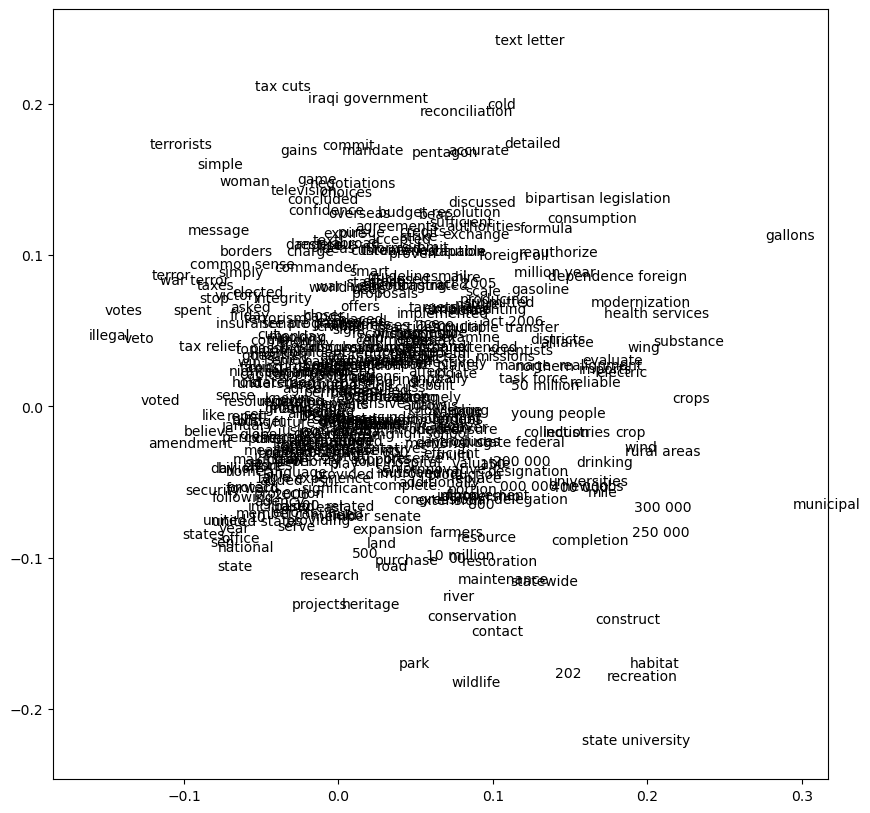

In [132]:
# dim1 vs dim2
plt.figure(figsize = [10,10])
plt.scatter(col_df[0], col_df[1], alpha = 0)
for i, var in enumerate(col_df.index):
    plt.text(col_df.iloc[i,0], col_df.iloc[i,1], var)

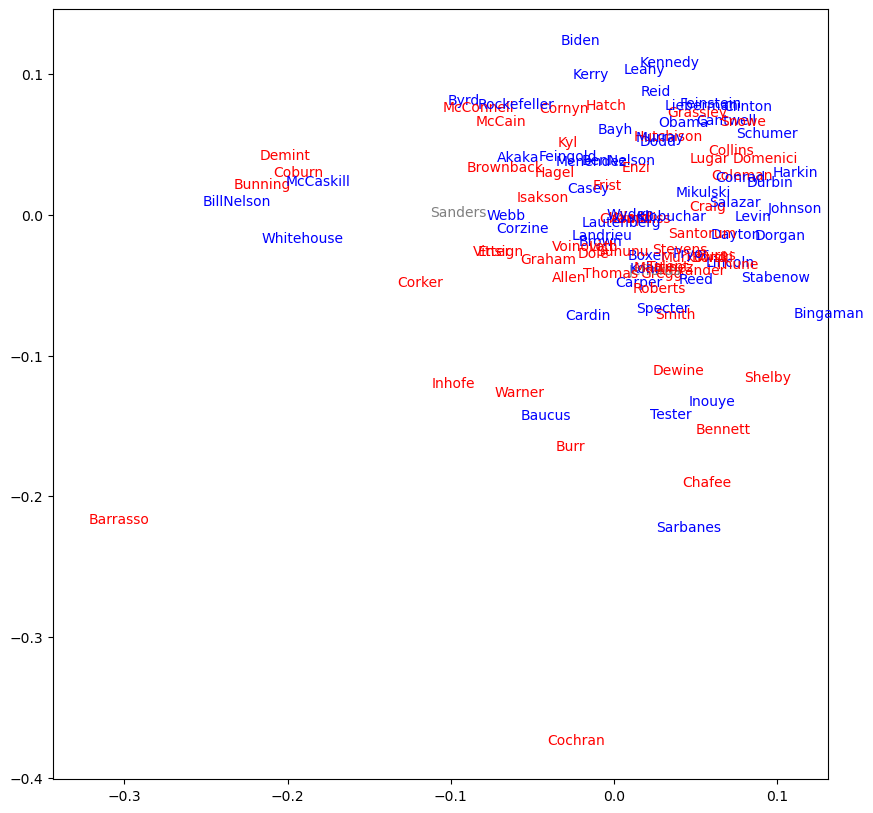

In [133]:
# dim1 vs dim2
plt.figure(figsize = [10,10])
plt.scatter(row_df[0], row_df[1], alpha = 0)
for i, var in enumerate(row_df.index):
    if party_dict[var] == 'Republican':
        color = 'red'
    elif party_dict[var]  == 'Democrat':
        color = 'blue'
    else:
        color = 'grey'
    plt.text(row_df.iloc[i,0], row_df.iloc[i,1], var, color = color)

The result does not look super bad. Republican senators and Democrat senators are to some extant separable. But if we look at the feature (column) space, it is pretty messy. The problem is that some of the unigrams and bigrams are not that much informative. And I can hardly make sense of the dimensions.

# CA with feature engineering

Let's try harder. This time, I will select my features more carefully to make them more informative. I turn to statistically significant bigrams and trigrams. To speed up computation, I am only going to get my bigrams and trigrams from a 5% sample of the full text. When you run the code, you will get a different sample than mine. 

In [39]:
sample_df = grimmer_df.sample(frac = 0.05) # get a 5% sample from the full corpus 
sample_df['tokens'] = sample_df['text'].apply(lambda x: word_tokenize(x)) # tokenize each text in the sample 

In [43]:
sample_tokens = sample_df['tokens'].sum() # get a list of all tokens

In [40]:
Bigrams = nltk.collocations.BigramCollocationFinder.from_words(sample_tokens) # get all the bigrams from the tokens 

And, we will use the likelihood ratio test to get the top 500 statistically significant bigrams. 

In [134]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
top_bigrams = Bigrams.score_ngrams(bigram_measures.likelihood_ratio)[:500]
top_bigrams = [' '.join(bigram[0]) for bigram in top_bigrams]
print(top_bigrams)

['united states', 'u s', 'of the', 'i am', 'more than', 'the the', 'the senate', 'homeland security', 'will be', 'in the', 'it is', 'health care', 'department of', 'has been', 'new york', 'president bush', 'have been', 'washington dc', 'the to', 'fire departments', 'the and', 'd c', 'supreme court', 'immediate release', 'law enforcement', 'the united', 'on the', 'white house', 'fiscal year', 'our nation', 'for the', 'email email', 'funding for', 'million for', 'as well', 'ensure that', 'be used', '202 224', 'am pleased', 'in iraq', 'is a', 'appropriations bill', 'part of', 'air force', 'today announced', 'we can', 'to be', 'washington d', 'as a', 'the president', 'member of', 'will help', 'look forward', 'to ensure', 'we have', 'following statement', 'american people', 'low income', 'well as', 'last year', 'need to', 'by the', 'such as', 'continue to', 'we must', 'my colleagues', 'to make', 'to to', 'first responders', 'able to', 'social security', 'we are', 'latest news', 'new mexico'

We will do the same from trigrams but use t-tests instead. 

In [135]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
Trigrams = nltk.collocations.TrigramCollocationFinder.from_words(sample_tokens)
top_trigrams = Trigrams.score_ngrams(trigram_measures.student_t)[:500]
top_trigrams = [' '.join(trigram[0]) for trigram in top_trigrams]
print(top_trigrams)

['the united states', 'the department of', 'of the senate', 'member of the', 'the u s', 'u s senator', 'washington d c', 'as well as', 'to ensure that', 'a member of', 'of homeland security', 'the american people', 'million for the', 'for immediate release', 'one of the', 'department of homeland', 'i am pleased', 'chairman of the', 'the federal government', 'in the senate', 'part of the', 'be used to', 'we need to', 'the following statement', 'will be used', 'men and women', 'the white house', 'today announced that', 'will continue to', 'as part of', 'look forward to', 'in order to', 'they need to', 'members of the', 'united states senator', 'funding for the', 'this funding will', 'email email email', 'be able to', 'the bush administration', 'the number of', 'of the united', 'state and local', 'announced that the', 'in the united', "our nation 's", 'included in the', 'as a result', 'across the country', 'department of defense', 'the fiscal year', 'this is a', "the president 's", 'senat

We combine the bigrams and trigrams to get our features. To make my CA replicable, I saved mine in a pickle. Un-comment the last two lines if you want to save yours. 

In [156]:
features = top_bigrams + top_Trigrams
print(sorted(features)) # print all the features sorted by alphabets
features = sorted(features)[23:] # It looks like the ones starting with numbers are not much meaningful, I decide to skip the first 23.
#with open("features.pkl", 'wb') as f:
    #pickle.dump(features, f)

['$ 1 million', '$ 2 million', '000 for', '000 for the', '1 million', '1 million for', '2 million', '2 million for', '2005 washington', '2005 washington d', '2007 washington', '2007 washington d', '2007 washington dc', '202 224', '202 224 2633', '202 228', '202/228 1122', '21st century', '224 2633', '3 million', '5 million', '5 million for', '500 000', '9 11', 'a and', 'a bipartisan', 'a letter', 'a letter to', 'a long way', 'a lot of', 'a member', 'a member of', 'a new', 'a number of', 'a of', 'a result', 'a result of', 'a senior member', 'a series of', 'a the', 'a time when', 'a to', 'a total of', 'a variety of', 'a vote of', 'ability to', 'able to', 'access to', 'access to the', 'according to', 'according to the', 'across the', 'across the country', 'across the nation', 'act of', 'act of 2005', 'act of 2006', 'act of 2007', 'active duty', 'air force', 'air force base', 'air national guard', 'al qaeda', 'all of the', 'all of us', 'along with', 'am pleased', 'am pleased that', 'am ple

For the following analysis, I am using the features saved in my pickle. If you use yours, you will get a different result. 

In [158]:
with open("features.pkl", 'rb') as f:
    features = pickle.load(f)

Again, we use sklearn's count function to get the counts of all bigrams and trigrams. 

In [159]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words = 'english',  max_df = 0.5, min_df = 0.01,  ngram_range = (2,3))
GrimmerVects = ngCountVectorizer.fit_transform(grimmer_df['text'])

We want to make sure that our selected bigrams and trigrams appear in the count matrix, and we get their row ids. There are 194 of them that meet the document frequency thresholds. 

In [160]:
features = list(set(ngCountVectorizer.vocabulary_.keys()) & set(features))
feature_ids = [ngCountVectorizer.vocabulary_[feature] for feature in features]
print(len(features))

194


Then, we contruct our imput matrix as before.

In [161]:
countdf = pd.DataFrame(GrimmerVects[:,feature_ids].todense(), columns = features)

In [162]:
count_df = pd.concat([grimmer_df.senator, countdf], axis = 1)
senator_df = count_df.groupby('senator').sum()
senator_df = senator_df.loc[:,(senator_df.skew() < 20) & (senator_df.kurtosis() < 20)]
ncols = senator_df.shape[1]

In [163]:
model = mca.MCA(np.log(senator_df + 1), ncols = ncols, benzecri=False)
row_scores = model.fs_r(N=5)
col_scores = model.fs_c(N=5)
col_df = pd.DataFrame(col_scores, index = senator_df.columns)
row_df = pd.DataFrame(row_scores, index = senator_df.index)

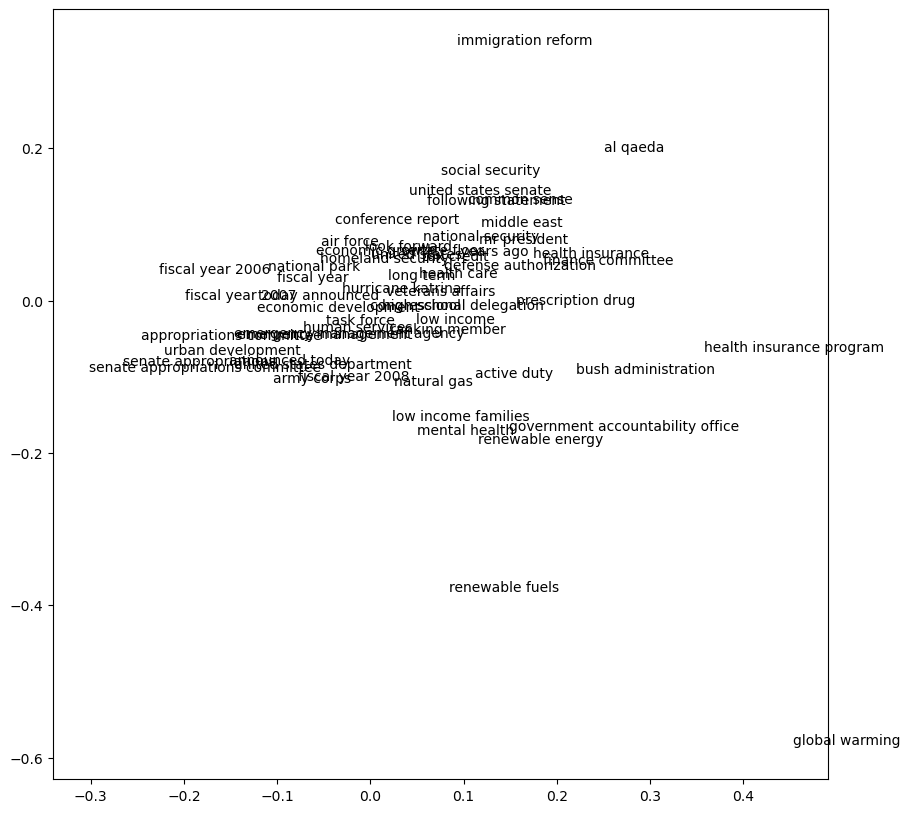

In [164]:
# dim1 vs dim2
plt.figure(figsize = [10,10])
plt.scatter(col_df[0], col_df[1], alpha = 0)
for i, var in enumerate(col_df.index):
    plt.text(col_df.iloc[i,0], col_df.iloc[i,1], var)

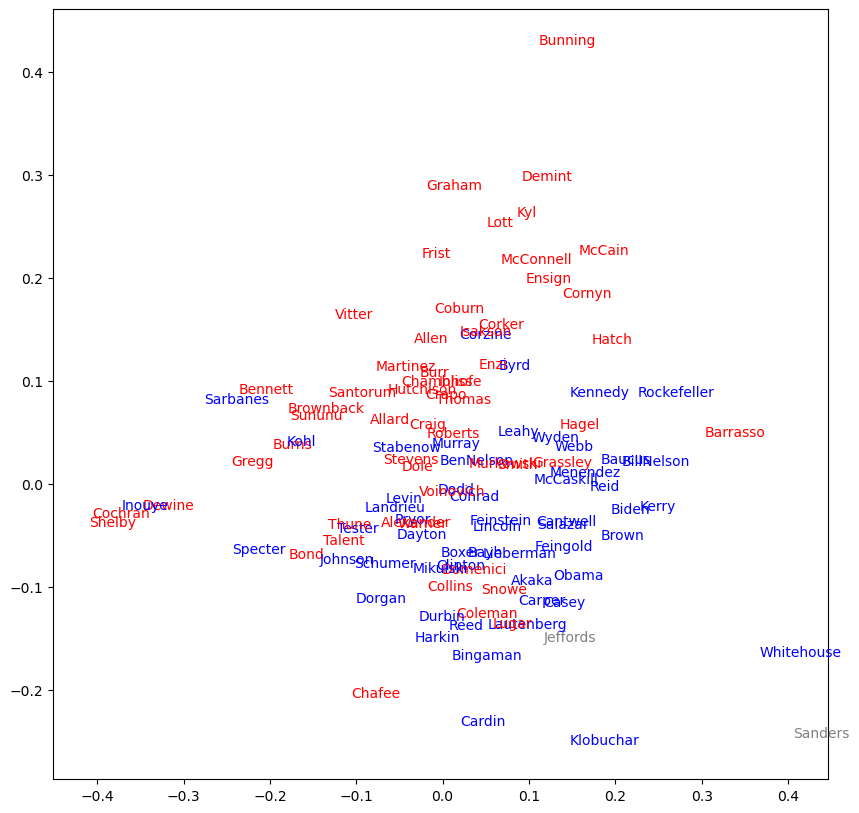

In [165]:
# dim1 vs dim2
plt.figure(figsize = [10,10])
plt.scatter(row_df[0], row_df[1], alpha = 0)
for i, var in enumerate(row_df.index):
    if party_dict[var] == 'Republican':
        color = 'red'
    elif party_dict[var]  == 'Democrat':
        color = 'blue'
    else:
        color = 'grey'
    plt.text(row_df.iloc[i,0], row_df.iloc[i,1], var, color = color)

With selected features, we improve the quality of our results. The Republicans and Democrats are better separated in the row space. And the column space also looks more meaningful. It looks like the second dimension (vertical axis) is especially useful for separating Democrats from Republicans. We have 'immigration reform' (presumably a Republican issue) at the one end, and 'renewable fuels' and 'global warming' at the other end. Note how distant away 'global warning' is from other issues. The text was collected from 2005 to 2007. At the time, only Senator Whitehouse and Senator Sanders were closely associated with this issue. They are from Rhode Island and Vermont, two small states that are very liberal-leaning. 

## Lesson

Feature engineering is a dark art. When there is too much noise in the data, statistical methods can't help too much. In this notebook, I tried a little bit to improve the quality of the features in my imput matrix. But I am certain that there is a lot of room for improvement. You could also try to use some more sofisticated models (like topic models or word embeddings) to generate better features. 